In [97]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import dill as pickle
import figurefirst as fifi
import figure_functions as ff
import util
from drone_model_constant_wind import DroneSimulator
from drone_observability import DroneObservability

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set trajectory

In [98]:
dt = 0.1  # sampling time [s]
fs = 1 / dt  # sampling frequency [hz]
T = 11.0  # total time [s]
tsim = np.arange(0, T + dt/2, step=dt) # time vector [s]

In [99]:
# Set the ambient wind
w = 1.0 * np.ones_like(tsim)
zeta = np.pi * np.ones_like(tsim)

# Set altitude
z =  2.0 * np.ones_like(tsim)  # elevation

In [100]:
g0 = 1.0
t0 = 1.0

v_x =  g0 * np.ones_like(tsim) + 0.0 * tsim
v_y =  0.01 * np.ones_like(tsim) + 0.0 * tsim
psi = (-np.pi/4) * np.ones_like(tsim)
psi_global = -(np.pi/4) * np.ones_like(tsim)

index = int((0.5 + t0) * fs)
v_x[index:] = v_x[index] - 3*g0/4

index = int((3.0 + t0) * fs)
v_x[index:] = v_x[index] + 3*g0/4

index = int((4.0 + t0) * fs)
psi[index:] = psi[index] + np.pi/2

index = int((6.9 + t0) * fs)
psi[index:] = psi[index] + np.pi/1.3

index = int((8.0 + t0) * fs)
tsim_temp = tsim[index:]
tsim_temp = tsim_temp - tsim_temp[0]
psi_temp = -(np.pi/3)*np.sin(2*np.pi*0.6*tsim_temp + np.pi/2) + 0.0*(np.pi/6)*np.cos(2*np.pi*1.0*tsim_temp + np.pi/3)
psi_temp = psi_temp - psi_temp[0]
# psi_temp = util.wrapTo2Pi(psi_temp)
psi[index:] = psi[index] + psi_temp

index = int((8.0 + t0) * fs)
psi[index:] = psi[index:] + np.pi/2

# Global course
x_dot = v_x * np.cos(psi_global) + v_y * np.sin(psi_global)
y_dot = v_x * np.sin(psi_global) + v_y * np.cos(psi_global)

index = int((5.5 + t0) * fs)
psi_global[index:] = psi_global[index] - np.pi/2

index = int((6.9 + t0) * fs)
psi_global[index:] = psi_global[index] + np.pi/2

v_x = x_dot * np.cos(psi_global) + y_dot * np.sin(psi_global)
v_y = y_dot * np.cos(psi_global) - x_dot * np.sin(psi_global)

# Simulate trajectory

In [101]:
mpc_horizon = 10
mpc_control_penalty = 1e-2

In [102]:
# Create simulator
simulator = DroneSimulator(dt=dt, mpc_horizon=mpc_horizon, r_u=mpc_control_penalty)

# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta)

# Run
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)

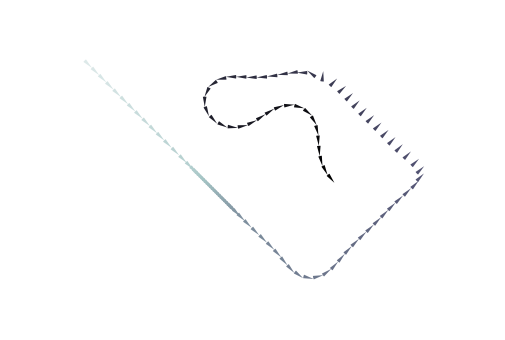

In [103]:
simulator.plot_trajectory(size_radius=0.1)

# Compute observability

In [104]:
simulator = DroneObservability(simulator=DroneSimulator, dt=0.1, polar=True,
                               states=None, sensors=None, time_steps=None,
                               mpc_horizon=mpc_horizon, mpc_control_penalty=mpc_control_penalty)

In [105]:
data_dict = simulator.run(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta, R=1e-2, lam=1e-6)

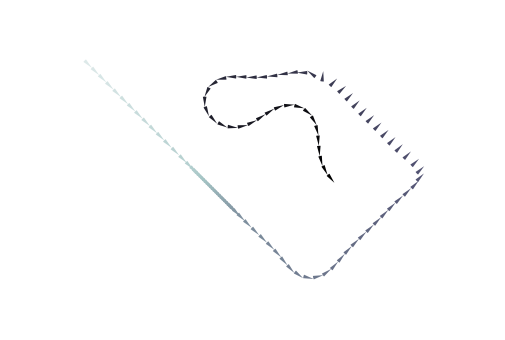

In [106]:
simulator.plot_trajectory()

In [107]:
index_map, n_sensors, n_states, n_time_steps = util.get_indices(data_dict,
                                                                states_list=simulator.states,
                                                                sensors_list=simulator.sensors,
                                                                time_steps_list=simulator.time_steps)

# Select states, sensors, time-steps combination

In [108]:
states_index = 0
sensors_index = 1
time_steps_index = 4

j = index_map[sensors_index, states_index, time_steps_index]
sim_data = data_dict['sim_data'][j]
error_variance = data_dict['error_variance'][j].copy()
error_variance = error_variance.fillna(method='bfill').fillna(method='ffill')

print('states:', data_dict['states'][j])
print('sensors:', data_dict['sensors'][j])
print('time-steps:', data_dict['time_steps'][j])

states: ['x', 'y', 'z', 'g', 'beta', 'v_z', 'phi', 'theta', 'psi', 'omega_x', 'omega_y', 'omega_z', 'w', 'zeta', 'm', 'I_x', 'I_y', 'I_z', 'C']
sensors: ['psi', 'gamma', 'beta']
time-steps: 5


# Plot state observability

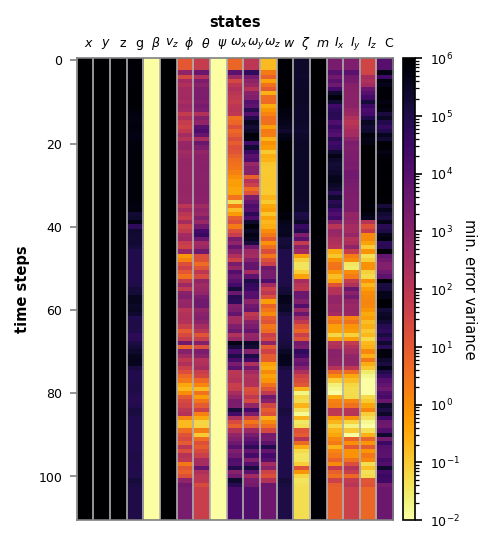

In [109]:
EV = error_variance.iloc[:, 2:]
cnorm, cmap, log_ticks = ff.plot_heatmap_log_timeseries(EV.values, data_labels=list(EV.columns),
                                                        log_ticks=(-2, 6), y_label='min. error variance')

# Plot state observability on trajectory

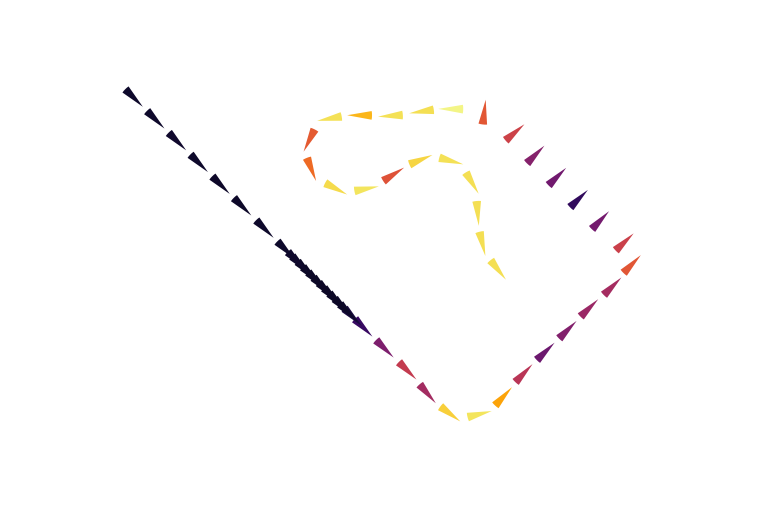

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(3 * 1, 3 * 1), sharex=True, sharey=True, dpi=300)

o_var = 'zeta'

ff.plot_trajectory(sim_data['x'].values, sim_data['y'].values, sim_data['psi'].values,
                   color=error_variance[o_var].values,
                   ax=ax,
                   size_radius=0.16,
                   nskip=1,
                   colormap=cmap,
                   colornorm=cnorm)

fifi.mpl_functions.adjust_spines(ax, [])

# Save

In [111]:
save_dir = os.path.join(os.pardir, 'data', 'simulated')

In [112]:
save_name_prefix = 'custom_trajectory'
print(save_name_prefix)

custom_trajectory


In [113]:
# Save
if save_name_prefix != '':
    save_path = os.path.join(save_dir, save_name_prefix + '.pk')
    with open(save_path, 'wb') as handle:
        pickle.dump({'data': [data_dict]}, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Reload to make sure it saved correctly
    if save_name_prefix != '':
        with open(save_path, 'rb') as handle:
            datain = pickle.load(handle)

        print(datain.keys())
        print(datain['data'][0].keys())

dict_keys(['data'])
dict_keys(['states', 'sensors', 'time_steps', 'sim_data', 'error_variance', 'O_sliding'])
